A.S. Lundervold, v.060124

# Introduction

This is a first, straightforward example of using fastai for image classification. See Module 1 on the course Canvas for more details. 

> This is not a stand-alone notebook. Remember to also work through the Module 1 notebooks from the [fastai course](https://course.fast.ai/) and the [fastai book](https://github.com/fastai/fastbook).

# Setup

**These first cells are included to make sure we can run the notebook locally and on both Google Colab and Kaggle:**

In [ ]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [ ]:
# This is copied from Howard's notebook: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data


#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# Make sure we're using the latest version of fastai
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai

In [ ]:
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('/kaggle/input/')

**Checking for GPU/MPS availability:**

If you're running on a Mac with Metal Performance Shaders (M-series), some features of PyTorch aren't supported. Therefore, we add a fallback:

In [1]:
import os
import torch

if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

Then we check for GPU/MPS:

In [2]:
import fastai.torch_core

device = None
if torch.cuda.is_available():
    device = fastai.torch_core.default_device('cuda')
elif torch.backends.mps.is_available():
    device = fastai.torch_core.default_device('mps')
else:
    device = fastai.torch_core.default_device('cpu')

In [3]:
print(device)

cuda:0


> **Explanation:** The above code checks for the availability of a GPU or MPS (Metal Performance Shaders, used in Apple's M1/M2 chips) to accelerate model training. If neither is available, it defaults to using the CPU. Using GPU or MPS significantly speeds up deep learning tasks.

# Load and inspect some data

Let's keep things simple by using one of the data sets collected in the repository fast.ai Datasets (https://course.fast.ai/datasets). You'll find the options using the previous link, or by looking at list of `URLs`:

In [4]:
from fastai.data.all import URLs

In [5]:
print([d for d in dir(URLs) if "__" not in d])

['ADULT_SAMPLE', 'AG_NEWS', 'AMAZON_REVIEWS', 'AMAZON_REVIEWS_POLARITY', 'BIWI_HEAD_POSE', 'BIWI_SAMPLE', 'CALTECH_101', 'CAMVID', 'CAMVID_TINY', 'CARS', 'CIFAR', 'CIFAR_100', 'COCO_SAMPLE', 'COCO_TINY', 'CUB_200_2011', 'DBPEDIA', 'DOGS', 'FLOWERS', 'FOOD', 'GOOGLE', 'HUMAN_NUMBERS', 'IMAGENETTE', 'IMAGENETTE_160', 'IMAGENETTE_320', 'IMAGEWANG', 'IMAGEWANG_160', 'IMAGEWANG_320', 'IMAGEWOOF', 'IMAGEWOOF_160', 'IMAGEWOOF_320', 'IMDB', 'IMDB_SAMPLE', 'LOCAL_PATH', 'LSUN_BEDROOMS', 'MACAQUES', 'MDL', 'ML_100k', 'ML_SAMPLE', 'MNIST', 'MNIST_SAMPLE', 'MNIST_TINY', 'MNIST_VAR_SIZE_TINY', 'MT_ENG_FRA', 'OPENAI_TRANSFORMER', 'PASCAL_2007', 'PASCAL_2012', 'PETS', 'PLANET_SAMPLE', 'PLANET_TINY', 'S3', 'S3_AUDI', 'S3_COCO', 'S3_IMAGE', 'S3_IMAGELOC', 'S3_MODEL', 'S3_NLP', 'SIIM_SMALL', 'SOGOU_NEWS', 'TCGA_SMALL', 'URL', 'WIKITEXT', 'WIKITEXT_TINY', 'WT103_BWD', 'WT103_FWD', 'YAHOO_ANSWERS', 'YELP_REVIEWS', 'YELP_REVIEWS_POLARITY', 'ZEBRA_FINCH', 'path']


**Loading the CIFAR-10 dataset:**

We'll use a famous benchmark data set widely studied by the computer vision community: [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html).

This dataset comprises 60,000 32x32 color images divided into 10 different classes, each representing a distinct category, such as airplanes, cars, birds, cats, etc. With 6,000 images per category, CIFAR-10 offers a balanced dataset that is both challenging and accessible for beginners in deep learning.

<img src="assets/cifar-10.png">

Our goal is to create an image classifier. More specifically, this notebook is designed to guide you through using `fastai` to build a model that can accurately classify images from the CIFAR-10 dataset.


In [6]:
from fastai.vision.all import *
# Download and prepare the CIFAR-10 dataset
path = untar_data(URLs.CIFAR)

> **Explanation:** We import all necessary modules from the FastAI vision library here. The untar_data function is then used to download and extract the CIFAR-10 dataset from FastAI's dataset repository. This function simplifies the process of acquiring and preparing data for use.

In [7]:
path.ls()

(#3) [Path('/home/alex/.fastai/data/cifar10/train'),Path('/home/alex/.fastai/data/cifar10/labels.txt'),Path('/home/alex/.fastai/data/cifar10/test')]

In [9]:
get_image_files(path)[:5]

(#5) [Path('/home/alex/.fastai/data/cifar10/train/airplane/32703_airplane.png'),Path('/home/alex/.fastai/data/cifar10/train/airplane/1524_airplane.png'),Path('/home/alex/.fastai/data/cifar10/train/airplane/43002_airplane.png'),Path('/home/alex/.fastai/data/cifar10/train/airplane/48197_airplane.png'),Path('/home/alex/.fastai/data/cifar10/train/airplane/5194_airplane.png')]

**Creating a DataBlock:**

In [10]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # Define data types for the input and output
    get_items=get_image_files,                      # Function to get image files
    splitter=GrandparentSplitter(train_name='train', 
                                 valid_name='test'),# Split data based on grandparent folder name
    get_y=parent_label,                             # Get labels from parent folder names
    item_tfms=Resize(224),                          # Resize images to 224x224
    batch_tfms=[
        *aug_transforms(),                          # Apply some data augmentation (see Chapter 2)
        Normalize.from_stats(*imagenet_stats)       # Normalize image intensities (because pretraining)
    ]
)

> **Explanation:** This sets up a DataBlock, a versatile FastAI tool for building datasets. It specifies the data types (images and categories), how to retrieve images and labels, and how to split the dataset (80% for training and 20% for validation). The item_tfms and batch_tfms apply transformations such as resizing and data augmentation, which are crucial for improving model robustness and handling varying image sizes.

In [11]:
dls = data.dataloaders(path, bs=64)

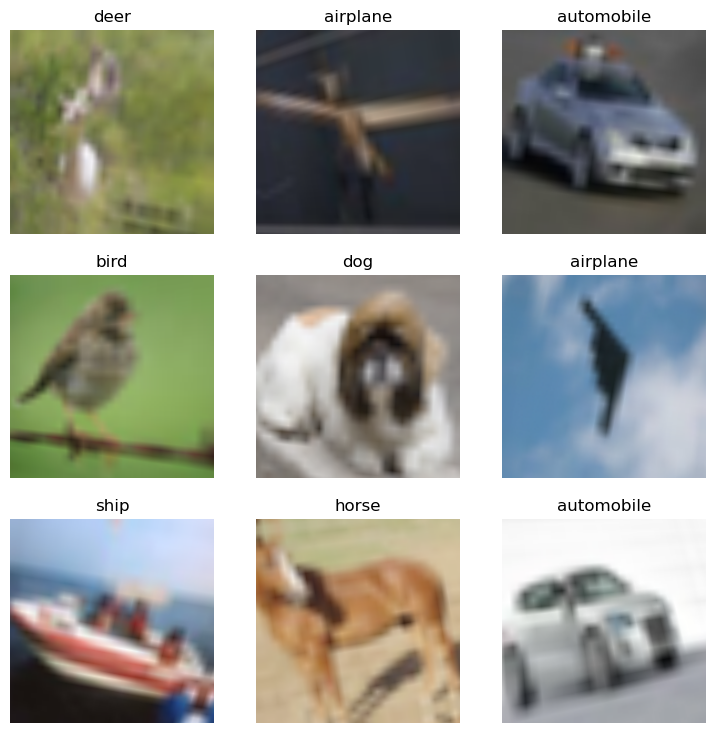

In [12]:
dls.show_batch()

We can inspect the effect of data augmentation on an image by passing in the `unique=True` argument to `show_batch()`:

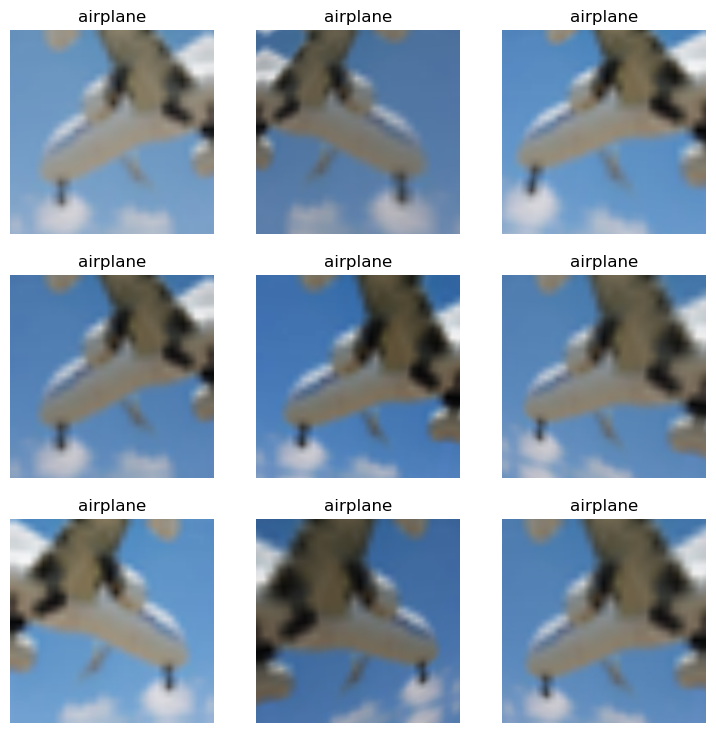

In [13]:
dls.show_batch(unique=True)

# Train a model

We use a version of the ResNet34 model pre-trained on the ImageNet dataset. This architecture reasonably balances performance and complexity and is often an excellent first choice. 

In [14]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

In [15]:
# Train the model for 1 epoch with everything frozen except head, then 4 unfrozen
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.593090,0.354691,0.879100,01:18


epoch,train_loss,valid_loss,accuracy,time
0,0.301101,0.211751,0.929000,01:44
1,0.209680,0.163745,0.943100,01:45
2,0.118592,0.118657,0.961000,01:45
3,0.064713,0.106662,0.964200,01:44


> **Explanation:** Here, we use FastAI's `vision_learner` to create a convolutional neural network based on the ResNet34 architecture, a popular choice for image classification. The `fine_tune` method trains the model by first adjusting the parameters of new layers added for our specific task and then adjusting the parameters of the entire network. The number 4 indicates the number of epochs or complete passes through the dataset.

# Evaluate

Here are some results:

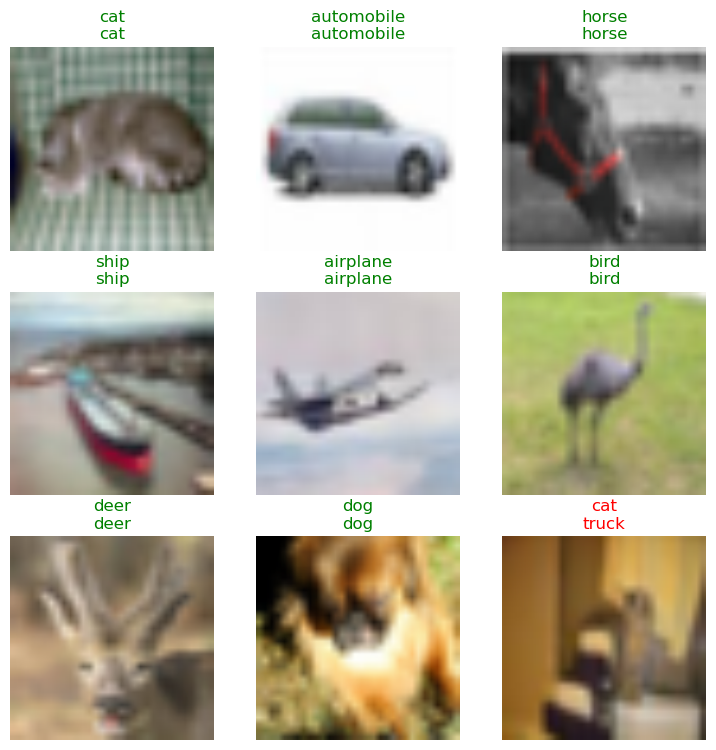

In [18]:
learn.show_results()

We obtain an accuracy of about 96.4%, which means that

360 of the test images were misclassified:

In [19]:
10000*(1-0.964)

360.00000000000034

Let's dig more into the misclassifications: 

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

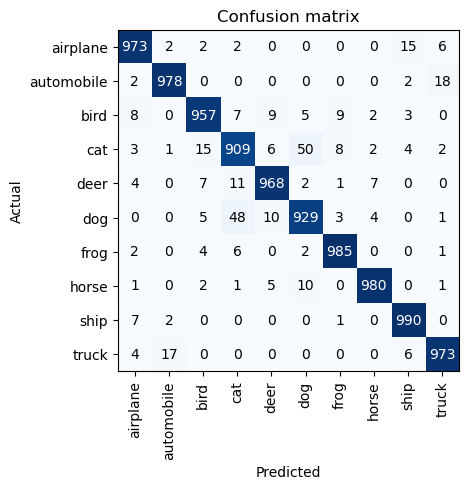

In [21]:
interp.plot_confusion_matrix()

In [22]:
interp.most_confused()

[('cat', 'dog', 50),
 ('dog', 'cat', 48),
 ('automobile', 'truck', 18),
 ('truck', 'automobile', 17),
 ('airplane', 'ship', 15),
 ('cat', 'bird', 15),
 ('deer', 'cat', 11),
 ('dog', 'deer', 10),
 ('horse', 'dog', 10),
 ('bird', 'deer', 9),
 ('bird', 'frog', 9),
 ('bird', 'airplane', 8),
 ('cat', 'frog', 8),
 ('bird', 'cat', 7),
 ('deer', 'bird', 7),
 ('deer', 'horse', 7),
 ('ship', 'airplane', 7),
 ('airplane', 'truck', 6),
 ('cat', 'deer', 6),
 ('frog', 'cat', 6),
 ('truck', 'ship', 6),
 ('bird', 'dog', 5),
 ('dog', 'bird', 5),
 ('horse', 'deer', 5),
 ('cat', 'ship', 4),
 ('deer', 'airplane', 4),
 ('dog', 'horse', 4),
 ('frog', 'bird', 4),
 ('truck', 'airplane', 4),
 ('bird', 'ship', 3),
 ('cat', 'airplane', 3),
 ('dog', 'frog', 3),
 ('airplane', 'automobile', 2),
 ('airplane', 'bird', 2),
 ('airplane', 'cat', 2),
 ('automobile', 'airplane', 2),
 ('automobile', 'ship', 2),
 ('bird', 'horse', 2),
 ('cat', 'horse', 2),
 ('cat', 'truck', 2),
 ('deer', 'dog', 2),
 ('frog', 'airplane', 2),

Here are the images that were misclassified with the highest loss / greatest confidence:

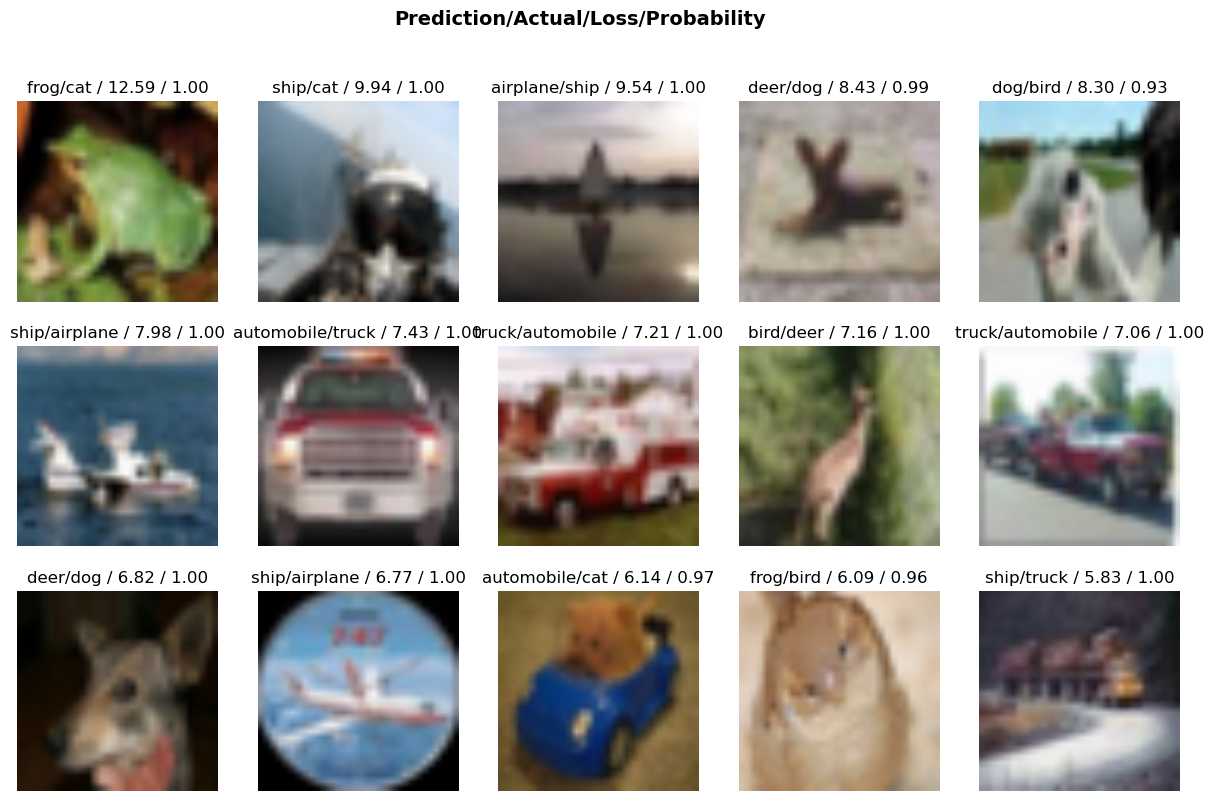

In [23]:
interp.plot_top_losses(15, nrows=3)

> This was a simple example. Later, we'll learn many tricks that can be used to increase performance. In fact, CIFAR10 turns out to be way too simple as a benchmark dataset for modern deep learning-based computer vision methods.

# Your turn!

**Experiment with different architectures**

> Beyond ResNet34, explore other neural network architectures like ResNet50, AlexNet, or VGG16. Observe how the choice of architecture impacts training time and accuracy.

**Hyperparameter tuning**

> Experiment with different learning rates, batch sizes, and numbers of epochs. Understand how these hyperparameters affect the model's performance and training dynamics.

**Error analysis**

> Dive deeper into the misclassified images. Try to find patterns or common characteristics among these errors. This can lead to insights about the dataset, model, and potential areas for improvement.

**Different data set**

> Try out the same approach on a different data set. For example, try the PETS dataset. 